# Different aproach for timeseries prediction

1. Simple univariate timeseries
2. Multivariate timeseries
3. One-step, long and short term predictions

Standard pipline:
1. Split data (train, valid, test)
2. Fit model on train 
3. Tune hyperparam on valid
4. Predict on test and choose model
5. Upfit/refit on test
5. Forecast in future

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge
import warnings
from itertools import product
from tqdm.notebook import tqdm

In [2]:
import statsmodels.api as sm
from statsmodels import tsa
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [2]:
import sys
external_path = '../../frameworks/time_series_signals_sound'
sys.path.append(external_path)

In [3]:
from metrics import timeseries_metrics
from plots import ts_plots
from modeling import multistep
from preprocessing import feature_generation

In [20]:
from sklearn.linear_model import LinearRegression, Lasso

### 1. Load raw data

In [5]:
data = pd.read_csv('../../data/3/data/total_mass.csv', index_col=0, parse_dates=True)
test_data = pd.read_csv('../../data/3/data/test_total_mass.csv', index_col=0, parse_dates=True)

In [21]:
new_data = pd.read_csv('../../data/3/data/SD568103a.csv', sep=';', encoding='utf-8')

In [22]:
new_data.columns

Index(['Страна приема', 'Месяц импорта', 'Первые символы ШИ',
       'Последние символы ШИ', 'Тип отправления', 'Количество отправлений',
       'Вес отправлений'],
      dtype='object')

In [10]:
new_data['Страна приема'].unique()

array(['Афганистан', 'Албания', 'Антарктика', 'Алжир', 'Восточное Самоа',
       'Андорра', 'Ангола', 'Антигуа и Барбуда', 'Азербайджан',
       'Аргентина', 'Австралия', 'Австрия', 'Багамские острова',
       'Бахрейн', 'Бангладеш', 'Армения', 'Барбадос', 'Бельгия',
       'Бермудские острова', 'Бутан', 'Боливия', 'Босния и Герцеговина',
       'Ботсвана', 'Буве острова', 'Бразилия', 'Белиз',
       'Британские территории в Индийском Океане', 'Соломоновы острова',
       'Британские Виргинские острова', 'Бруней', 'Болгария', 'Мьянма',
       'Бурунди', 'Беларусь', 'Камбоджа', 'Камерун', 'Канада',
       'Кабо-Верде', 'Каймановы острова',
       'Центрально-Африканская Республика', 'Шри Ланка', 'Чад', 'Чили',
       'Китай', 'Тайвань', 'Рождества остров', 'Кокос острова',
       'Колумбия', 'Коморские острова', 'Майотт остров',
       'Республика Конго', 'Демократическая Республика Конго',
       'Кука острова', 'Коста-Рика', 'Хорватия', 'Куба', 'Кипр', 'Чехия',
       'Бенин', 'Дания'

In [146]:
data.head()
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2010-01-31 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mass    120 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


,mass
count,1.200000e+02
mean,3.182448e+06
std,1.624320e+06
min,0.000000e+00
25%,2.124026e+06
50%,3.343083e+06
75%,4.230413e+06
max,7.247583e+06


In [147]:
test_data.head()
test_data.info()
test_data.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9 entries, 2020-01-31 to 2020-09-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mass    9 non-null      float64
dtypes: float64(1)
memory usage: 144.0 bytes


,mass
count,9.000000e+00
mean,4.061208e+06
std,9.593335e+05
min,2.274910e+06
25%,3.499716e+06
50%,4.347695e+06
75%,4.529642e+06
max,5.320047e+06


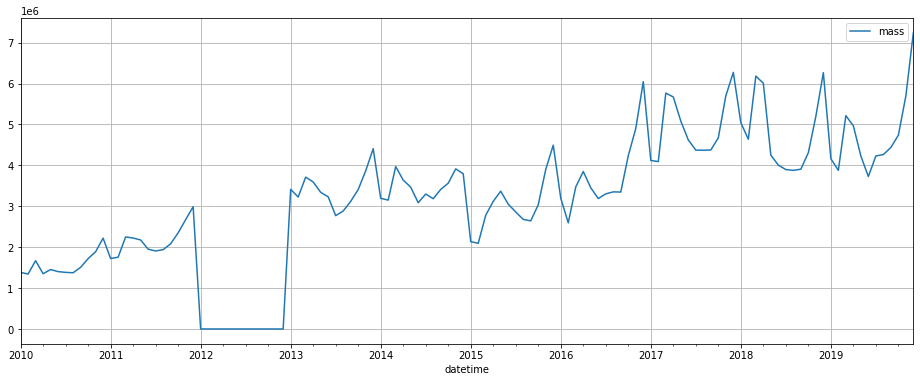

In [7]:
data.plot(figsize=(16,6))
plt.grid()
plt.show()

### 2. Interpolate miss data

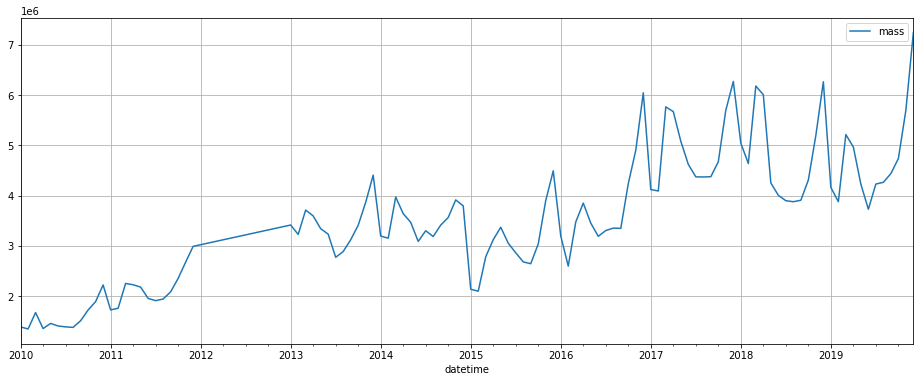

In [6]:
data = data.replace(0, np.nan).interpolate()
data.plot(figsize=(16,6))
plt.grid()
plt.show()

### 3. Split train and test data

In [7]:
train_data = data.loc[:'2019-01-01']
valid_data = data.loc['2019-01-01':]

### 4. Decompose train data and transform to stationarity

Populating the interactive namespace from numpy and matplotlib


<Figure size 1152x576 with 0 Axes>

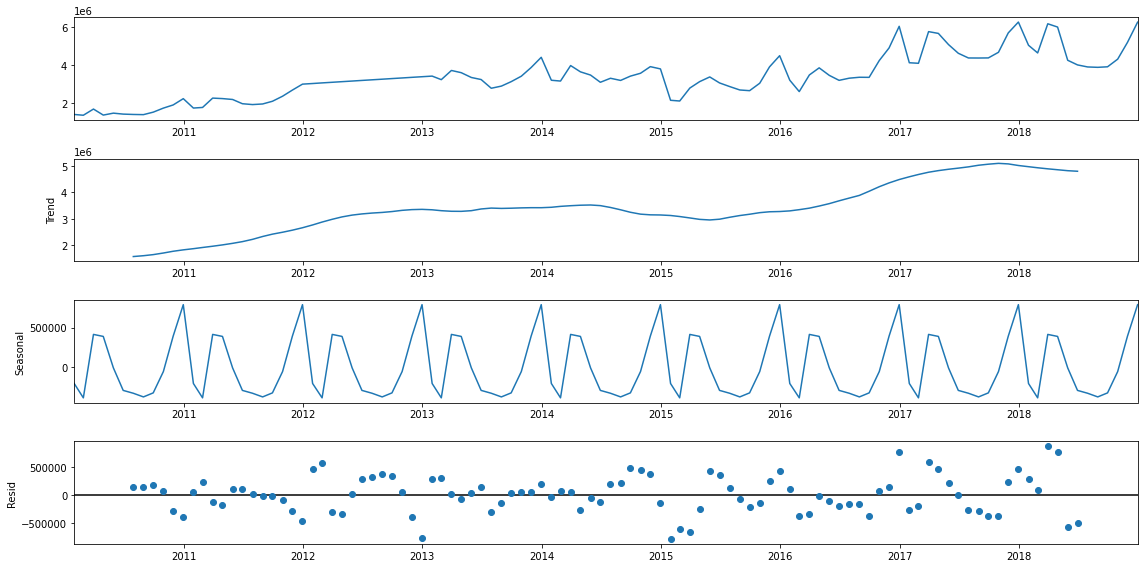

In [102]:
%pylab inline
#warnings.filterwarnings('ignore')
plt.figure(figsize(16,8))
decomp = tsa.seasonal.seasonal_decompose(train_data, freq=12)
decomp.plot()
plt.show()

# Adaptive prediction

In [130]:
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import Holt

In [168]:
exp_sm_m = ExponentialSmoothing(train_data,
                              trend="additive",
                              seasonal="additive",
                              seasonal_periods=12).fit(optimized=True)

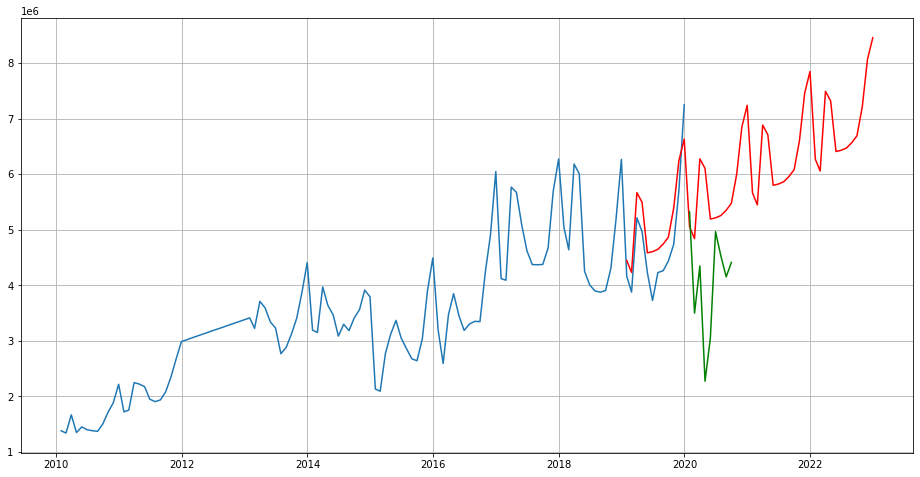

In [169]:
predicted_steps = 48
start = len(train_data)
pred  = exp_sm_m.forecast(predicted_steps)
plt.figure(figsize=(16,8))
plt.plot(data)
plt.plot(pred, c='r')
plt.plot(test_data, c='g')
plt.grid()
plt.show()

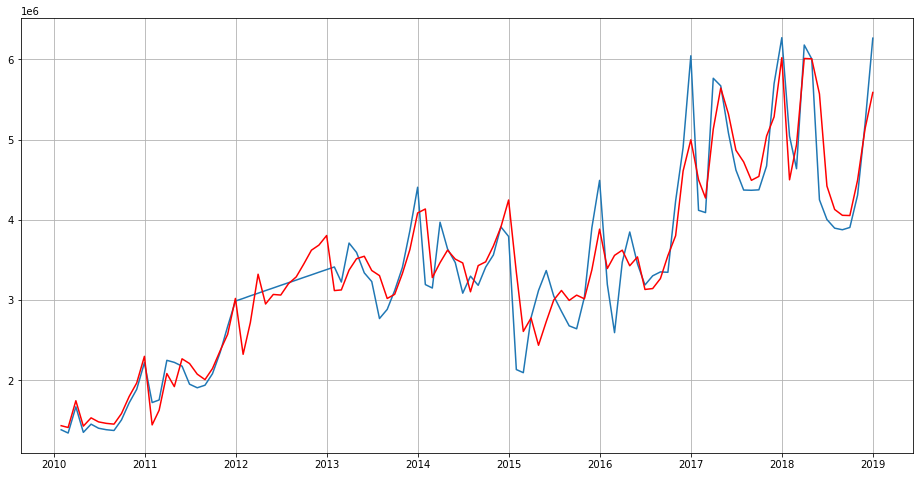

In [170]:
pred = exp_sm_m.predict(0, 107)
plt.figure(figsize=(16,8))
plt.plot(train_data)
plt.plot(pred, c='r')
plt.grid()
plt.show()

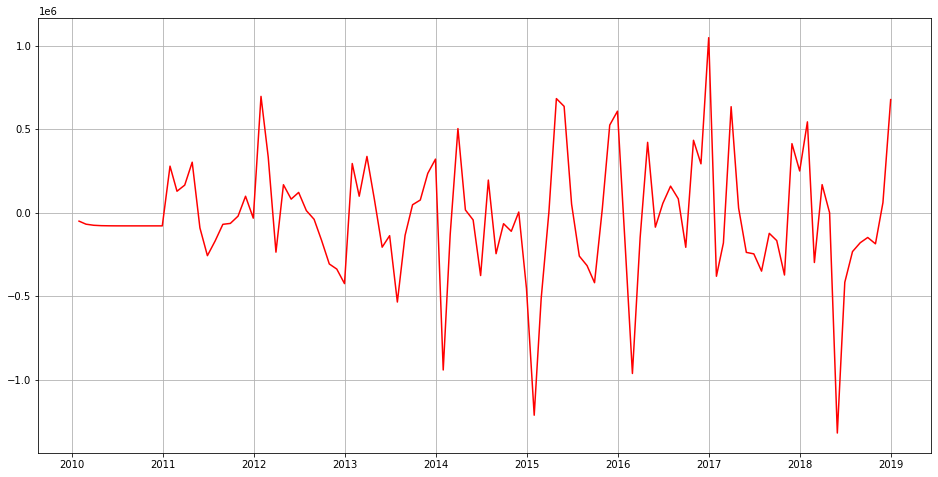

In [171]:
resid  = exp_sm_m.resid
plt.figure(figsize=(16,8))
plt.plot(resid, c='r')
plt.grid()
plt.show()

## Quality

In [172]:
timeseries_metrics.mape(train_data['mass'], pred)

0.07958742900013557

In [173]:
timeseries_metrics.resampled_error(train_data['mass'], pred, 'Y', timeseries_metrics.mape)

0.01927118353453293

In [174]:
predicted_steps = 12
start = len(train_data)
valid_pred  = exp_sm_m.predict(start=start, end=start + predicted_steps)

timeseries_metrics.mape(valid_data['mass'], valid_pred)

0.108225026784862

In [175]:
timeseries_metrics.resampled_error(valid_data['mass'], valid_pred, 'Y', timeseries_metrics.mape)

0.08377558975710962

In [176]:
test_steps = 9
start = len(train_data)
test_pred  = exp_sm_m.predict(start=start + predicted_steps, end=start + predicted_steps + test_steps)

timeseries_metrics.mape(test_data['mass'], test_pred)

0.44433962426701545

In [177]:
timeseries_metrics.resampled_error(test_data['mass'], test_pred, 'Y', timeseries_metrics.mape)

0.333762621458153

# SARIMAX

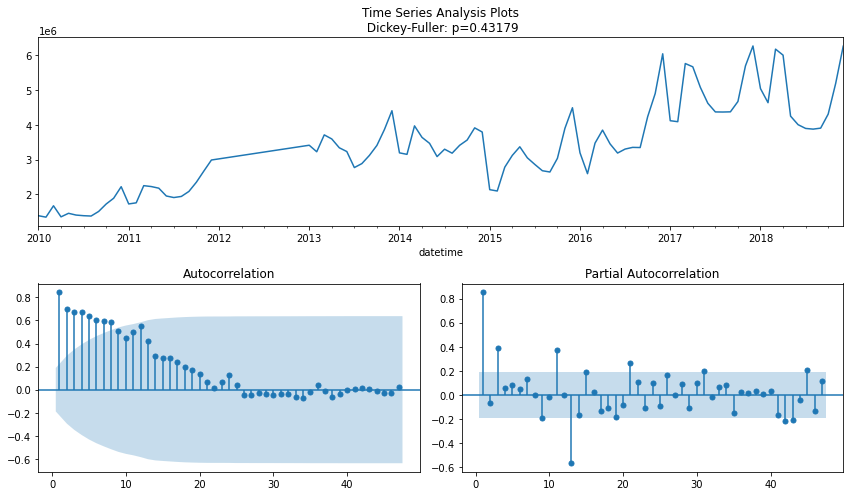

In [101]:
ts_plots.tsplot(train_data['mass'], 48)

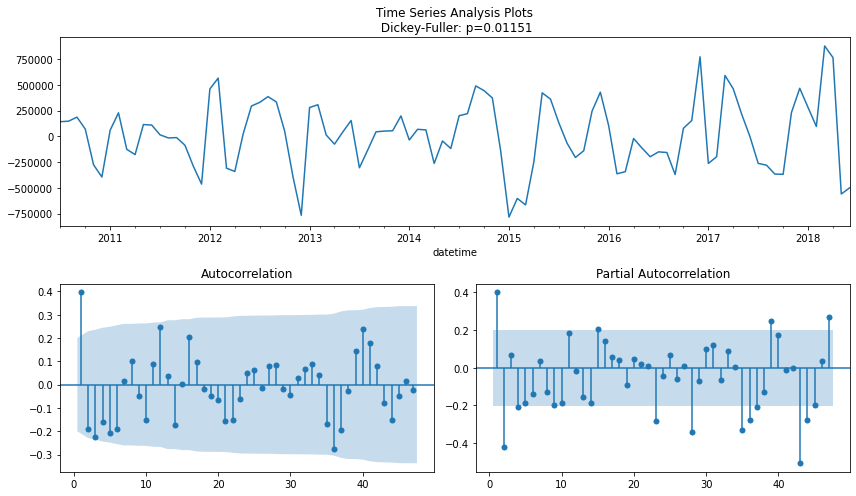

In [107]:
ts_plots.tsplot(decomp.resid.dropna(), 48)

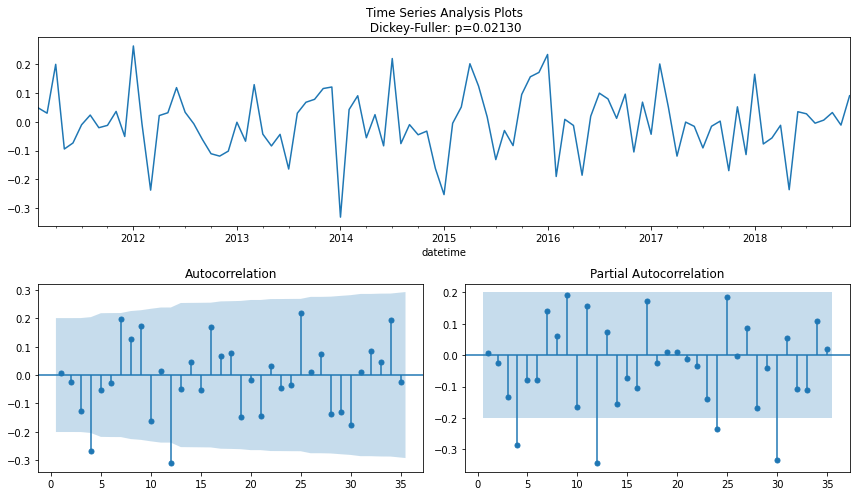

In [100]:
ts_plots.tsplot(np.log1p(train_data['mass']).diff(1).diff(12)[13:], 36)

In [10]:
'''
Q - номер последнего сезонного лага при котором автокореляци значима
q - номер последнего несезонного лага при при котором автокореляци значима
'''
Q=1
q=2

'''
P - номер последнего сезонного лага при котором частичная автокореляци значима
p - номер последнего несезонного лага при при котором частичной автокореляция значима
'''
P=1
p=3

# setting initial values and some bounds for them
ps = list(range(0, p+1))
d=1 
qs = list(range(0, q+1))
Ps = list(range(0, P+1))
D=1 
Qs = list(range(0, Q+1))
s = 12 # season length is still 24
# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

48

In [11]:
def optimizeSARIMA(parameters_list, d, D, s, endog, exog=None):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")
    warnings.filterwarnings('ignore')
    for param in tqdm(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(endog, exog=exog, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results, columns=['parameters', 'aic'])
    
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return best_model, result_table

In [12]:
best_model, res = optimizeSARIMA(parameters_list, d, D, s, train_data['mass'])

In [75]:
res.head()

,parameters,aic
0,"(0, 0, 1, 0)",2700.430730
1,"(1, 0, 1, 0)",2702.277352
2,"(0, 1, 1, 0)",2702.474836
3,"(1, 1, 1, 0)",2702.794283
4,"(0, 0, 1, 1)",2702.864383


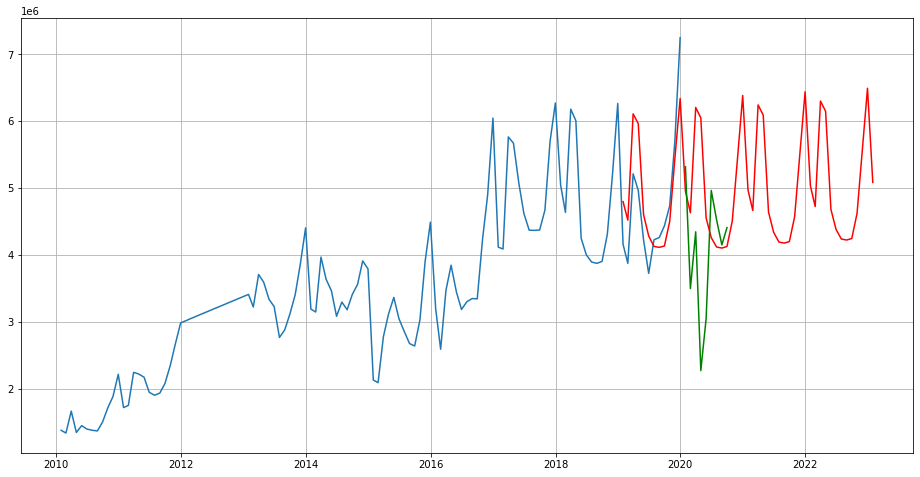

In [178]:
predicted_steps = 48
start = len(train_data)
pred  = best_model.predict(start=start, end=start + predicted_steps)
plt.figure(figsize=(16,8))
plt.plot(data)
plt.plot(pred, c='r')
plt.plot(test_data, c='g')
plt.grid()
plt.show()

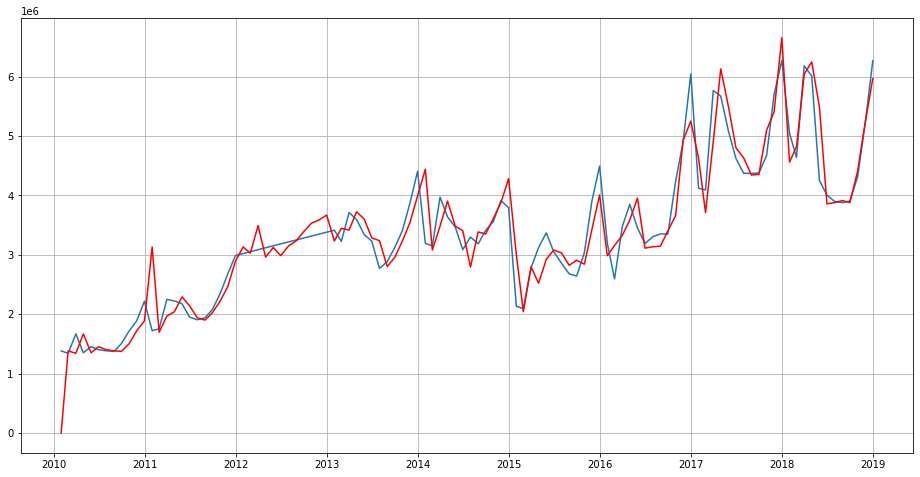

In [187]:
pred  = best_model.predict()
plt.figure(figsize=(16,8))
plt.plot(train_data)
plt.plot(pred, c='r')
plt.grid()
plt.show()

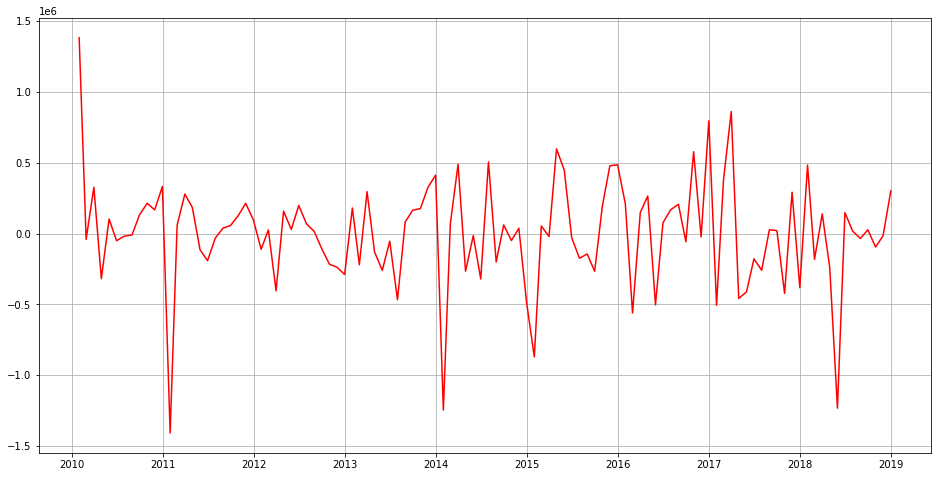

In [180]:
resid  = best_model.resid
plt.figure(figsize=(16,8))
plt.plot(resid, c='r')
plt.grid()
plt.show()

## Quality
### Train metrics

In [181]:
timeseries_metrics.mape(train_data['mass'], pred)

0.08962005086681968

In [182]:
timeseries_metrics.resampled_error(train_data['mass'], pred, 'Y', timeseries_metrics.mape)

0.03265511530258589

### Valid metrics

In [183]:
predicted_steps = 12
start = len(train_data)
valid_pred  = best_model.predict(start=start, end=start + predicted_steps)

timeseries_metrics.mape(valid_data['mass'], valid_pred)

0.1064759208297923

In [184]:
timeseries_metrics.resampled_error(valid_data['mass'], valid_pred, 'Y', timeseries_metrics.mape)

0.03813237475136013

In [185]:
test_steps = 9
start = len(train_data)
test_pred  = best_model.predict(start=start + predicted_steps, end=start + predicted_steps + test_steps)

timeseries_metrics.mape(test_data['mass'], test_pred)

0.3644074945547049

In [186]:
timeseries_metrics.resampled_error(test_data['mass'], test_pred, 'Y', timeseries_metrics.mape)

0.1767359420804091

# Multistep prediction aproach

Statsmodel library has internal forecasting algorithm  based on recurcisve forecast, if we want use ML models for multistep prediction we need to use some of this strategies:

1. Direct Multi-step Forecast Strategy
The direct method involves developing a separate model for each forecast time step.

Example:

    prediction(t+1) = model1(obs(t-1), obs(t-2), ..., obs(t-n))
    prediction(t+2) = model2(obs(t-2), obs(t-3), ..., obs(t-n))


2. Recursive Multi-step Forecast
The recursive strategy involves using a one-step model multiple times where the prediction for the prior time step is used as an input for making a prediction on the following time step.

Example:

    prediction(t+1) = model(obs(t-1), obs(t-2), ..., obs(t-n))
    prediction(t+2) = model(prediction(t+1), obs(t-1), ..., obs(t-n))


3. Direct-Recursive Hybrid Strategies
The direct and recursive strategies can be combined to offer the benefits of both methods.

For example, a separate model can be constructed for each time step to be predicted, but each model may use the predictions made by models at prior time steps as input values.

Example:

    prediction(t+1) = model1(obs(t-1), obs(t-2), ..., obs(t-n))
    prediction(t+2) = model2(prediction(t+1), obs(t-1), ..., obs(t-n))
    
    
4. Multiple Output Strategy
The multiple output strategy involves developing one model that is capable of predicting the entire forecast sequence in a one-shot manner.

Example:

	prediction(t+1), prediction(t+2) = model(obs(t-1), obs(t-2), ..., obs(t-n))


## Regresion aproach

1. Modeling simple regression for ts
    - add feature (trend, seasonality etc)
    - find residuals
2. Modeling residuals with SARIMA

In [31]:
lags = feature_generation.generate_lags(train_data, window_size=24).dropna()
diffs = feature_generation.generate_diffs(train_data, window_size=24).dropna()
features = pd.merge(lags, diffs, left_index=True,  right_index=True, how='inner')

In [33]:
f, t = feature_generation.direct_forecast_feature(features,
                                                  'lag_1', 
                                                  steps=12)
dir_ms = multistep.DirectForecast(LinearRegression, steps=12)
dir_ms.fit(f, t)
pred = pd.Series(dir_ms.predict(f[1].iloc[-1].to_frame().T), index=pd.date_range(valid_data.index[0], 
                                                                                 periods=12, freq='M'))

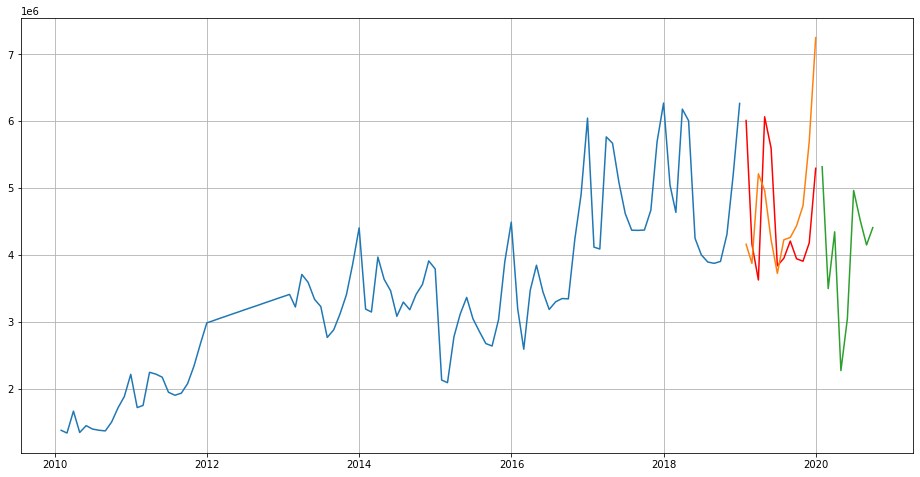

In [34]:
plt.figure(figsize=(16,8))
plt.plot(train_data)
plt.plot(pred, c='r')
plt.plot(valid_data)
plt.plot(test_data)
plt.grid()
plt.show()

In [40]:
lags = feature_generation.generate_lags(data, window_size=36).dropna()
diffs = feature_generation.generate_diffs(data, window_size=36).dropna()
features = pd.merge(lags, diffs, left_index=True,  right_index=True, how='inner')

In [41]:
f, t = feature_generation.direct_forecast_feature(features,
                                                  'lag_1', 
                                                  steps=9)
dir_ms = multistep.DirectForecast(LinearRegression, steps=9)
dir_ms.fit(f, t)
pred = pd.Series(dir_ms.predict(f[1].iloc[-1].to_frame().T), index=pd.date_range(test_data.index[0], 
                                                                                 periods=9, freq='M'))

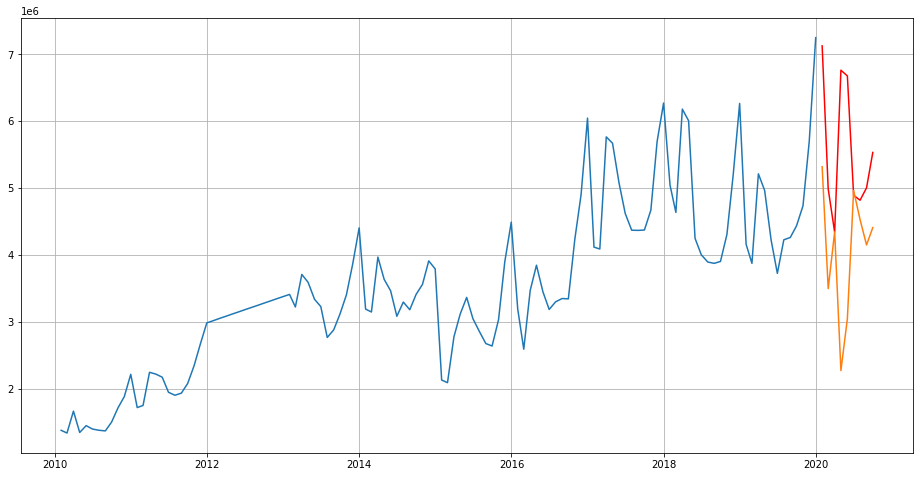

In [43]:
plt.figure(figsize=(16,8))
plt.plot(data)
plt.plot(pred, c='r')
plt.plot(test_data)
plt.grid()
plt.show()

In [47]:
# from tsfresh import extract_features
# from tsfresh.utilities.dataframe_functions import roll_time_series

# raw_data = train_data.reset_index()
# raw_data['id'] = 1
# df_rolled = roll_time_series(raw_data, column_id="id", column_sort="datetime")
# extracted_features = extract_features(df_rolled, column_id='id', column_sort='datetime')